## BayesNN 实现 mnist 数据分类

### 第一步：加载 mnist 数据集

In [1]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
K = tf.keras
tfd = tfp.distributions

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


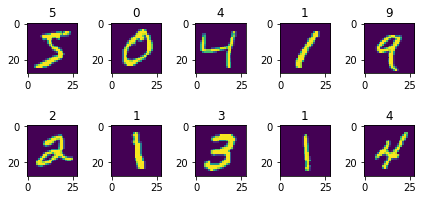

In [2]:
def get_minibatch(x, y, n_batch, n_iter):
    num = x.shape[0]
    for idx in range(0, n_iter):
        perm = np.random.permutation(num)[0:n_batch]
        batchx = x[perm]
        batchy = y[perm]
        yield batchx, batchy

# Load Dataset
(m_xtr,m_ytr),(m_xte,m_yte) = K.datasets.mnist.load_data()
m_xtr = np.expand_dims(m_xtr,3)/255.
m_xte = np.expand_dims(m_xte,3)/255.
# m_ytr = np.expand_dims(m_ytr,1)
# m_yte = np.expand_dims(m_yte,1)
print(m_xtr.shape, m_xte.shape, m_ytr.shape, m_yte.shape)

#for batchx, batchy in get_minibatch(m_xtr, m_ytr, 10):
batchx = m_xtr[0:10]
batchy = m_ytr[0:10]
plt.figure(figsize=[6,3])
for i in range(0,10):
    plt.subplot(2,5,i+1)
    plt.imshow(batchx[i].reshape(28,28))
    plt.title(batchy[i])
plt.tight_layout()
plt.show()


### 第二步：构建 Bayes Neural Network

In [3]:
# Define The Model
neural_net = tf.keras.Sequential([
    tfp.layers.Convolution2DFlipout(6, kernel_size=5, padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME"),
    tfp.layers.Convolution2DFlipout(16, kernel_size=5, padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2], padding="SAME"),
    tfp.layers.Convolution2DFlipout(120, kernel_size=5, padding="SAME", activation=tf.nn.relu),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(84, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(10)
    ])
images = tf.placeholder(tf.float32, shape=[None, 28,28,1])
labels = tf.placeholder(tf.float32, shape=[None])
logits = neural_net(images)
labels_distribution = tfd.Categorical(logits=logits)

# Loss
neg_log_likelihood = -tf.reduce_mean(labels_distribution.log_prob(labels))
kl = sum(neural_net.losses) / 60000
elbo_loss = neg_log_likelihood + kl
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(elbo_loss)
# Accuracy
predictions = tf.cast(tf.argmax(logits, axis=1),tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels, predictions), tf.float32))

# Train
sess = tf.Session()
sess.run(tf.global_variables_initializer())

niter = 1000
for i, [batchx, batchy] in enumerate(get_minibatch(m_xtr,m_ytr,64, niter)):
    fd = {images: batchx, labels: batchy} #training mode
    _, tracc, trloss = sess.run([train_op, accuracy, elbo_loss], feed_dict = fd)
    if i%100==0:
        teacc, teloss = sess.run([accuracy, elbo_loss], feed_dict={images:m_xte, labels:m_yte})
        print('{}/{}, tracc:{:.3f}, trloss:{:.4f}, teacc:{:.3f}, teloss:{:.4f}'.format(i, niter, tracc, trloss, teacc, teloss))

0/1000, tracc:0.062, trloss:26.8044, teacc:0.094, teloss:26.1210
100/1000, tracc:0.734, trloss:23.1531, teacc:0.802, teloss:23.1275
200/1000, tracc:0.875, trloss:22.3666, teacc:0.894, teloss:22.3903
300/1000, tracc:0.969, trloss:21.6541, teacc:0.913, teloss:21.8521
400/1000, tracc:0.891, trloss:21.4206, teacc:0.937, teloss:21.2632
500/1000, tracc:0.953, trloss:20.6886, teacc:0.946, teloss:20.7289
600/1000, tracc:0.938, trloss:20.2683, teacc:0.954, teloss:20.2024
700/1000, tracc:0.891, trloss:19.8504, teacc:0.954, teloss:19.6857
800/1000, tracc:0.969, trloss:19.1673, teacc:0.958, teloss:19.1647
900/1000, tracc:0.938, trloss:18.7176, teacc:0.961, teloss:18.6430


### 第三步：可视化不确定性

- 可视化模型预测的不确定性

In [ ]:
def plot_heldout_prediction(imgs, probs):
    n = imgs.shape[0]
    plt.figure(figsize=(9, 3*n))
    for i in range(n):
        plt.subplot(n, 3, 3*i+1)
        plt.imshow(imgs[i].reshape(28,28))
        plt.subplot(n, 3, 3*i+2)
        for mc_sample in probs:
            plt.bar(np.arange(10), mc_sample[i,:], alpha=0.1)
        plt.subplot(n, 3, 3*i+3)
        plt.bar(np.arange(10), np.mean(probs[:,i,:], axis=0))

imgs = m_xte[0:10]
num_mc = 50
probs = np.zeros([num_mc, imgs.shape[0], 10])
for i in range(num_mc):
    probs[i] = sess.run(labels_distribution.probs, feed_dict={images:imgs})
plot_heldout_prediction(imgs, probs)

(10, 28, 28, 1)
(50, 10, 10)
